In [237]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import re
import matplotlib.pyplot as plt
from IPython.display import display
pd.options.display.max_columns = None

import nltk
from nltk import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import ToktokTokenizer

stop_words = stopwords.words("english")
stop_words.remove("no")
stop_words.remove("not")

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

In [3]:
# Import the dataset to work with.
df = pd.read_csv('wiki_movie_plots_deduped.csv')

In [4]:
# Lets review some informaion about the dataframe
display(df.head(2))
display(df.shape)
display(df["Genre"].value_counts().head())
display("Unique genres values: {}".format(len(df["Genre"].value_counts())))
"""As We can see the Genre Data has a lot of unknown values (20% of the data) and has many variety
of genres (2265), so ill bring a new DataFrame from IMDB with the genres """

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."


(34886, 8)

unknown    6083
drama      5964
comedy     4379
horror     1167
action     1098
Name: Genre, dtype: int64

'Unique genres values: 2265'

'As We can see the Genre Data has a lot of unknown values (20% of the data) and has many variety\nof genres (2265), so ill bring a new DataFrame from IMDB with the genres '

In [5]:
# Lets import a new dataset with the genres. 
df_genre = pd.read_csv("title.basics.tsv",delimiter="\t")

/usr/local/Cellar/ipython/7.0.1/libexec/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
# Lets review some basic information about the new dataframe
display(df_genre.head(3))
df_genre.shape

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"


(5463542, 9)

In [7]:
# From the df_genre dataframe i just need the title of the movie and the genres column, so lets just work with that.
df_genre_used = df_genre[["primaryTitle","genres"]]
df_genre_used = df_genre_used.rename(columns={"primaryTitle":"Title"}) # I
df_genre_used.head()

,Title,genres
0,Carmencita,"Documentary,Short"
1,Le clown et ses chiens,"Animation,Short"
2,Pauvre Pierrot,"Animation,Comedy,Romance"
3,Un bon bock,"Animation,Short"
4,Blacksmith Scene,"Comedy,Short"


In [8]:
# Lets merge the dfs to add the genres to our original df
df_joined = df.merge(df_genre_used,on="Title").iloc[:30000]

In [9]:
# The original df had 34.886 rows only, the merged one has 261.399 rows, this mean that there are repeated movies.
display("shape of joined df: {}".format(df_joined.shape))

# Lets see how many unique movies we had (should be  <= 34.886 because the joined do a inner join)
display("Unique movies: {}".format(len(df_joined["Title"].unique().tolist())))

# Example of a repeated movie (42 times): 
jack = len(df_genre_used[df_genre_used["Title"]=="Jack and the Beanstalk"])
display("For example,the movie Jack and the Beanstalk appears {} times".format(jack))


'shape of joined df: (30000, 9)'

'Unique movies: 1902'

'For example,the movie Jack and the Beanstalk appears 42 times'

In [10]:
# Indeed, there are movies that repeat many times that we must clean. Lets just keep the columns that i need.
df_joined_c = df_joined.loc[:,("Release Year","Title","Plot","genres")]

# Lets get rid of genres movies that dont have any value in genres and the rows that are duplicates.
df_joined_c = df_joined_c[df_joined_c.loc[:,"genres"] !="\\N"]
df_joined_c.drop_duplicates(inplace=True)
display(df_joined_c.shape)
df_joined_c.head(3)

(16899, 4)

,Release Year,Title,Plot,genres
0,1901,Kansas Saloon Smashers,"A bartender is working at a saloon, serving dr...","Comedy,Short"
1,1901,Love by the Light of the Moon,"The moon, painted with a smiling face hangs ov...","Comedy,Fantasy,Romance"
2,1901,The Martyred Presidents,"The film, just over a minute long, is composed...",Short


In [11]:
empty = []
import time
def genres(movie):  
    genres = df_joined_c[df_joined_c["Title"]== movie]["genres"].tolist() # List of genres
    rel_year = df_joined_c[df_joined_c["Title"]== movie]["Release Year"].iloc[0] # real year 
    title = df_joined_c[df_joined_c["Title"]== movie]["Title"].iloc[0] # title
    plot = df_joined_c[df_joined_c["Title"]== movie]["Plot"].iloc[0] # plot
    list_genres = (",".join(genres)).split(",") # genres in list 
    genres_proc = pd.Series(list_genres).value_counts().index[:1].tolist() # Top 2 most repeated genres
    inf = {"Release_Year":rel_year,"Title":title,"Plot":plot,"Genres":genres_proc} # Final row to add
    empty.append(inf)

In [12]:
%%time
unique_titles = df_joined_c["Title"].unique().tolist()
for title in unique_titles:
    genres(title)

CPU times: user 31.1 s, sys: 452 ms, total: 31.5 s
Wall time: 1min 2s


In [13]:
movies = pd.DataFrame(empty)
movies.head(3)

,Genres,Plot,Release_Year,Title
0,[Short],"A bartender is working at a saloon, serving dr...",1901,Kansas Saloon Smashers
1,[Romance],"The moon, painted with a smiling face hangs ov...",1901,Love by the Light of the Moon
2,[Short],"The film, just over a minute long, is composed...",1901,The Martyred Presidents


In [14]:
movies["Genres"] = movies["Genres"].apply(np.sort)

In [15]:
movies.head(2)

,Genres,Plot,Release_Year,Title
0,[Short],"A bartender is working at a saloon, serving dr...",1901,Kansas Saloon Smashers
1,[Romance],"The moon, painted with a smiling face hangs ov...",1901,Love by the Light of the Moon


In [16]:
genres_array = np.array([])

for i in range(0,len(movies)):
    genres_array = np.concatenate((genres_array, movies['Genres'][i]))

genres_array

array(['Short', 'Romance', 'Short', ..., 'Crime', 'Comedy', 'Adventure'],
      dtype='<U32')

In [17]:
# Lets see thow many movies we have for each genre
gen_df = pd.DataFrame({"Genres":genres_array})
gen_df["Genres"] = gen_df["Genres"].apply(lambda x: "Musical" if x == "Music" else x)
gen_df["Count"] = 1 
mbg = gen_df.groupby("Genres").sum().sort_values(by="Count",ascending=False)
mbg


,Count
Genres,
Drama,703
Comedy,290
Romance,226
Short,201
Adventure,117
Mystery,60
Crime,49
Western,48
Musical,46


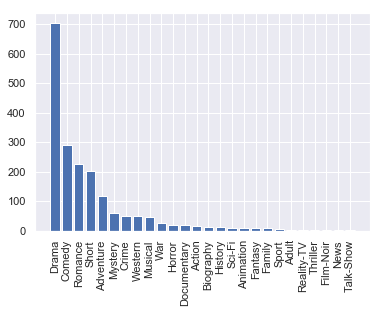

In [18]:
sns.set()
_ = plt.bar(mbg.index,mbg["Count"],label=mbg.index)
plt.xticks(rotation=90)
plt.show()

In [214]:
# Let create a frequency dist table for knowing in which categories lies the 98% of the values
gen_freq = mbg.reset_index()
gen_freq["Frequency"] = gen_freq["Count"]/len(gen_df)
gen_freq["Cumulative_Freq"] = gen_freq["Frequency"].cumsum()
gen_freq.head(8)

,Genres,Count,Frequency,Cumulative_Freq
0,Drama,703,0.370000,0.370000
1,Comedy,290,0.152632,0.522632
2,Romance,226,0.118947,0.641579
3,Short,201,0.105789,0.747368
4,Adventure,117,0.061579,0.808947
5,Mystery,60,0.031579,0.840526
6,Crime,49,0.025789,0.866316
7,Western,48,0.025263,0.891579


In [119]:
# List of Genres that add ups to ~ 98%. 
top_genres = np.array(gen_freq[(gen_freq["Cumulative_Freq"]<=0.85) & ( gen_freq["Genres"]!= "Short")]["Genres"])
top_genres

array(['Drama', 'Comedy', 'Romance', 'Adventure', 'Mystery'], dtype=object)

In [120]:
# Lets go back to the movies df and keep with the movies that have one of our main genres. 
# Lets change the genre music to musical 
movies["Genres"] = movies["Genres"].apply(lambda x: ["Musical" if word =="Music" else word for word in x])
movies["Main_Genres"] = movies["Genres"].apply(lambda x: np.array(x)[np.in1d(x,top_genres)])
movies.head(3)

,Genres,Plot,Release_Year,Title,Main_Genres
0,[Short],"A bartender is working at a saloon, serving dr...",1901,Kansas Saloon Smashers,[]
1,[Romance],"The moon, painted with a smiling face hangs ov...",1901,Love by the Light of the Moon,[Romance]
2,[Short],"The film, just over a minute long, is composed...",1901,The Martyred Presidents,[]


In [208]:
top_genres.tolist()
prueba_pelis = (movies[movies["Main_Genres"].str.len() != 0])

In [215]:
alo = pd.get_dummies(prueba_pelis["Main_Genres"].apply(lambda x: str(x[0])))
prueba_pelis2 = (pd.concat([prueba_pelis[["Plot"]],alo],axis=1))
prueba_pelis2.head()

,Plot,Adventure,Comedy,Drama,Mystery,Romance
1,"The moon, painted with a smiling face hangs ov...",0,0,0,0,1
8,The opening scene shows the interior of the ro...,0,1,0,0,0
9,Scenes are introduced using lines of the poem....,0,1,0,0,0
12,Irish villager Kathleen is a tenant of Captain...,0,0,1,0,0
17,A thug accosts a girl as she leaves her workpl...,1,0,0,0,0


In [144]:
movies = pd.concat([movies, movies.Main_Genres.apply(lambda x: ','.join(x)).str.get_dummies(sep=',')], axis=1)

In [216]:
index_drama = prueba_pelis2[prueba_pelis2["Drama"]==1].index.tolist()
index_drama_quitar = index_drama[:400]

index_usar = [num for num in prueba_pelis2.index.tolist() if num not in index_drama_quitar]
prueba_pelis2 = prueba_pelis2.loc[index_usar]

for cant in prueba_pelis2.columns:
    print((prueba_pelis2[cant]==1).sum())


0
117
290
303
60
226


In [217]:
movies["Release_Year"] = movies["Release_Year"].astype("category")
movies_cleaned = movies.drop(["Genres","Main_Genres"],axis=1)
movies_cleaned.head()

,Plot,Release_Year,Title,Adventure,Comedy,Drama,Mystery,Romance,Adventure,Comedy,Drama,Mystery,Romance,Adventure,Comedy,Drama,Mystery,Romance
0,"A bartender is working at a saloon, serving dr...",1901,Kansas Saloon Smashers,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"The moon, painted with a smiling face hangs ov...",1901,Love by the Light of the Moon,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1
2,"The film, just over a minute long, is composed...",1901,The Martyred Presidents,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Lasting just 61 seconds and consisting of two ...,1901,"Terrible Teddy, the Grizzly King",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,The earliest known adaptation of the classic f...,1902,Jack and the Beanstalk,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [197]:
lemma=WordNetLemmatizer()
token=ToktokTokenizer()
    
def lemitizeWords(text):
    words=token.tokenize(text)
    listLemma=[]
    for w in words:
        x=lemma.lemmatize(w,"v")
        listLemma.append(x)
    return listLemma
def stopWordsRemove(text):
    wordList =[x.lower().strip() for x in token.tokenize(text)]
    removedList=[x for x in wordList if not x in stop_words]
    text=" ".join(removedList)
    return text

def removeCharDigit(text):
    str="1234567890-=~@#$%^&*()_+[!{;”:\’><.,/?”}]"
    for w in text:
        if w in str:
            text=text.replace(w,"")
    return text
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

def PreProcessing(text):
    text =lemitizeWords(text)
    text =stopWordsRemove(text)
    text = removeCharDigit(text)
    return(text)


In [218]:
prueba = " ".join(prueba_pelis2[["Plot"]].iloc[0].tolist())
clean_text(PreProcessing(prueba))

'moon paint smile face hang park night young couple walk past fence learn rail look up moon smiles embrace moon smile get bigger sit bench tree moon view block cause frown last scene man fan woman hat moon leave sky perch shoulder see everything better'

In [230]:
#movies_cleaned["Plot_cleaned"] = movies_cleaned["Plot"].map(lambda com : PreProcessing(com))
prueba_pelis2["plot_cleaned"] = prueba_pelis2["Plot"].map(lambda x : clean_text(PreProcessing(x)))

In [ ]:
# # By now im just applyting remove_stopwords
# def tokenize(s):
#     return word_tokenize(s)

# def stem_and_lemmatize(l):
#     ps = PorterStemmer()
#     stemmed = [ps.stem(word).lower() for word in l]
#     lemmatizer = WordNetLemmatizer()
#     return [lemma.lemmatize(w,"v")(word) for word in stemmed]

# def remove_stopwords(l):
#     stopWords = set(stopwords.words('english'))
#     morewords = ["``","''","'s",] 
#     filtered = [word for word in l if word not in stopWords and word not in morewords and len(word)>1]
#     return filtered

In [231]:
prueba_pelis2.head()

,Plot,Adventure,Comedy,Drama,Mystery,Romance,plot_cleaned
1,"The moon, painted with a smiling face hangs ov...",0,0,0,0,1,moon paint smile face hang park night young co...
8,The opening scene shows the interior of the ro...,0,1,0,0,0,open scene show interior robbers den wall deco...
9,Scenes are introduced using lines of the poem....,0,1,0,0,0,scenes introduce use line poem santa claus pla...
17,A thug accosts a girl as she leaves her workpl...,1,0,0,0,0,thug accost girl leave workplace man rescue he...
33,"The film opens upon two sisters (Martha, playe...",0,0,0,0,1,film open upon two sisters martha play mary pi...


In [232]:
# Guarantee that each category it at least one time in the train.
from warnings import warn

def multilabel_sample(y, size=1000, min_count=5, seed=None):
    """ Takes a matrix of binary labels `y` and returns
        the indices for a sample of size `size` if
        `size` > 1 or `size` * len(y) if size =< 1.
        The sample is guaranteed to have > `min_count` of
        each label.
    """
    try:
        if (np.unique(y).astype(int) != np.array([0, 1])).any():
            raise ValueError()
    except (TypeError, ValueError):
        raise ValueError('multilabel_sample only works with binary indicator matrices')

    if (y.sum(axis=0) < min_count).any():
        raise ValueError('Some classes do not have enough examples. Change min_count if necessary.')

    if size <= 1:
        size = np.floor(y.shape[0] * size)

    if y.shape[1] * min_count > size:
        msg = "Size less than number of columns * min_count, returning {} items instead of {}."
        warn(msg.format(y.shape[1] * min_count, size))
        size = y.shape[1] * min_count

    rng = np.random.RandomState(seed if seed is not None else np.random.randint(1))

    if isinstance(y, pd.DataFrame):
        choices = y.index
        y = y.values
    else:
        choices = np.arange(y.shape[0])

    sample_idxs = np.array([], dtype=choices.dtype)

    # first, guarantee > min_count of each label
    for j in range(y.shape[1]):
        label_choices = choices[y[:, j] == 1]
        label_idxs_sampled = rng.choice(label_choices, size=min_count, replace=False)
        sample_idxs = np.concatenate([label_idxs_sampled, sample_idxs])

    sample_idxs = np.unique(sample_idxs)

    # now that we have at least min_count of each, we can just random sample
    sample_count = int(size - sample_idxs.shape[0])

    # get sample_count indices from remaining choices
    remaining_choices = np.setdiff1d(choices, sample_idxs)
    remaining_sampled = rng.choice(remaining_choices,
                                   size=sample_count,
                                   replace=False)

    return np.concatenate([sample_idxs, remaining_sampled])


def multilabel_sample_dataframe(df, labels, size, min_count=5, seed=None):
    """ Takes a dataframe `df` and returns a sample of size `size` where all
        classes in the binary matrix `labels` are represented at
        least `min_count` times.
    """
    idxs = multilabel_sample(labels, size=size, min_count=min_count, seed=seed)
    return df.loc[idxs]


def multilabel_train_test_split(X, Y, size, min_count=5, seed=None):
    """ Takes a features matrix `X` and a label matrix `Y` and
        returns (X_train, X_test, Y_train, Y_test) where all
        classes in Y are represented at least `min_count` times.
    """
    index = Y.index if isinstance(Y, pd.DataFrame) else np.arange(Y.shape[0])

    test_set_idxs = multilabel_sample(Y, size=size, min_count=min_count, seed=seed)
    train_set_idxs = np.setdiff1d(index, test_set_idxs)

    test_set_mask = index.isin(test_set_idxs)
    train_set_mask = ~test_set_mask

    return (X[train_set_mask], X[test_set_mask], Y[train_set_mask], Y[test_set_mask])

## Lets Split our data between train and test and test some classifiers

In [240]:
X = prueba_pelis2.loc[:,"Plot"]
y = prueba_pelis2.drop(["Plot","plot_cleaned"],axis=1)

X_train,X_test,y_train,y_test =  multilabel_train_test_split(X, y, size=0.2)
X_train.shape , X_test.shape, y_train.shape , y_test.shape

((797,), (199,), (797, 5), (199, 5))

In [252]:
from itertools import combinations

import numpy as np
from scipy import sparse
from sklearn.base import BaseEstimator, TransformerMixin


class SparseInteractions(BaseEstimator, TransformerMixin):
    def __init__(self, degree=2, feature_name_separator="_"):
        self.degree = degree
        self.feature_name_separator = feature_name_separator

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if not sparse.isspmatrix_csc(X):
            X = sparse.csc_matrix(X)

        if hasattr(X, "columns"):
            self.orig_col_names = X.columns
        else:
            self.orig_col_names = np.array([str(i) for i in range(X.shape[1])])

        spi = self._create_sparse_interactions(X)
        return spi

    def get_feature_names(self):
        return self.feature_names

    def _create_sparse_interactions(self, X):
        out_mat = []
        self.feature_names = self.orig_col_names.tolist()

        for sub_degree in range(2, self.degree + 1):
            for col_ixs in combinations(range(X.shape[1]), sub_degree):
                # add name for new column
                name = self.feature_name_separator.join(self.orig_col_names[list(col_ixs)])
                self.feature_names.append(name)

                # get column multiplications value
                out = X[:, col_ixs[0]]
                for j in col_ixs[1:]:
                    out = out.multiply(X[:, j])

                out_mat.append(out)

        return sparse.hstack([X] + out_mat)

In [254]:
# LogReg_pipeline = Pipeline([
#                 ('tfidf', TfidfVectorizer(stop_words=stop_words,ngram_range=(1,3))),
#                 ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
#             ])
TOKENS_ALPHANUMERIC = "[A-Za-z0-9]+(?=\\s+)"

LogReg_pipeline = Pipeline([
                ('vec', CountVectorizer(token_pattern = TOKENS_ALPHANUMERIC,ngram_range=(1,3))),
                ("int", SparseInteractions(degree=2)),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])

LogReg_pipeline.fit(X_train, y_train)
prediction = LogReg_pipeline.predict_proba(X_test)
pd.DataFrame(prediction)

KeyboardInterrupt: 

In [ ]:
for genre in np.array(y.columns):
    print('... Processing {}'.format(genre))
    # train the model using X_dtm & y
    LogReg_pipeline.fit(X_train, y_train[genre])
    # compute the testing accuracy
    prediction = LogReg_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(y_test[genre], prediction)))
    print(confusion_matrix(y_test[genre], prediction))
    print(classification_report(y_test[genre], prediction))

In [250]:
rf = Pipeline([
                ('vec', CountVectorizer(token_pattern = TOKENS_ALPHANUMERIC,ngram_range=(1,3))),
                ('clf', OneVsRestClassifier(RandomForestClassifier(n_estimators=10), n_jobs=1)),
            ])

rf.fit(X_train, y_train)
prediction = rf.predict_proba(X_test)
pd.DataFrame(prediction)

,0,1,2,3,4
0,0.1,0.1,0.1,0.0,0.0
1,0.1,0.0,0.1,0.0,0.0
2,0.0,0.1,0.1,0.0,0.0
3,0.0,0.0,0.1,0.0,0.1
4,0.0,0.1,0.1,0.0,0.0
5,0.1,0.0,0.1,0.0,0.1
6,0.1,0.1,0.1,0.0,0.1
7,0.0,0.3,0.0,0.0,0.1
8,0.1,0.4,0.5,0.0,0.1
9,0.1,0.0,0.1,0.1,0.3


In [249]:
for genre in np.array(y.columns):
    print('... Processing {}'.format(genre))
    # train the model using X_dtm & y
    rf.fit(X_train, y_train[genre])
    # compute the testing accuracy
    prediction = rf.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(y_test[genre], prediction)))
    print(confusion_matrix(y_test[genre], prediction))
    print(classification_report(y_test[genre], prediction))

... Processing Adventure
Test accuracy is 0.8844221105527639
[[176   0]
 [ 23   0]]
              precision    recall  f1-score   support

           0       0.88      1.00      0.94       176
           1       0.00      0.00      0.00        23

   micro avg       0.88      0.88      0.88       199
   macro avg       0.44      0.50      0.47       199
weighted avg       0.78      0.88      0.83       199

... Processing Comedy


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Test accuracy is 0.7386934673366834
[[145   0]
 [ 52   2]]
              precision    recall  f1-score   support

           0       0.74      1.00      0.85       145
           1       1.00      0.04      0.07        54

   micro avg       0.74      0.74      0.74       199
   macro avg       0.87      0.52      0.46       199
weighted avg       0.81      0.74      0.64       199

... Processing Drama
Test accuracy is 0.7236180904522613
[[139   3]
 [ 52   5]]
              precision    recall  f1-score   support

           0       0.73      0.98      0.83       142
           1       0.62      0.09      0.15        57

   micro avg       0.72      0.72      0.72       199
   macro avg       0.68      0.53      0.49       199
weighted avg       0.70      0.72      0.64       199

... Processing Mystery
Test accuracy is 0.9296482412060302
[[185   0]
 [ 14   0]]
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       185
           1    

/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Test accuracy is 0.7437185929648241
[[148   0]
 [ 51   0]]
              precision    recall  f1-score   support

           0       0.74      1.00      0.85       148
           1       0.00      0.00      0.00        51

   micro avg       0.74      0.74      0.74       199
   macro avg       0.37      0.50      0.43       199
weighted avg       0.55      0.74      0.63       199



/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
X = movies_cleaned.loc[:,"Plot_cleaned"]
y = movies_cleaned.iloc[:,3:-1]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.25)
X_train.shape , X_test.shape, y_train.shape , y_test.shape

In [ ]:
1 - len(y_test[y_test["Action"]==1])/len(y_test)

In [ ]:
LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])

LogReg_pipeline.fit(X_train, y_train)
prediction = LogReg_pipeline.predict_proba(X_test)
pd.DataFrame(prediction)

In [78]:
from sklearn.ensemble import RandomForestClassifier

rf = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', RandomForestClassifier()),
            ])

rf.fit(X_train, y_train)
accuracy = rf.score(X_test, y_test)
accuracy

# prediction = rf.predict_proba(X_test)
# pd.DataFrame(prediction)

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.3237822349570201

In [ ]:
contador_LR = 0    
for genre in np.array(y.columns):
    print('... Processing {}'.format(genre))
    # train the model using X_dtm & y
    LogReg_pipeline.fit(X_train, y_train[genre])
    # compute the testing accuracy
    prediction = LogReg_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(y_test[genre], prediction)))
    print(confusion_matrix(y_test[genre], prediction))
    print(classification_report(y_test[genre], prediction))
    contador_LR += accuracy_score(y_test[genre], prediction)

## SVC

In [ ]:
SVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1))
            ])

SVC_pipeline.fit(X_train, y_train)


La primera vez que hago el SVC e imprimo las matrices de confusion veo que hay colu

In [ ]:
contador_svc = 0    
for genre in np.array(y.columns):
    print('... Processing {}'.format(genre))
    # train the model using X_dtm & y
    SVC_pipeline.fit(X_train, y_train[genre])
    # compute the testing accuracy
    prediction = SVC_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(y_test[genre], prediction)))
    print(confusion_matrix(y_test[genre], prediction))
    print(classification_report(y_test[genre], prediction))
    contador_svc += accuracy_score(y_test[genre], prediction)

# SVC_pipeline.fit(X_train, y_train["Drama"])
# prediction = SVC_pipeline.predict(X_test)
# display(accuracy_score(y_test["Drama"], prediction))
# display(confusion_matrix(y_test["Drama"], prediction))
# print(classification_report(y_test["Drama"], prediction))
                 

## LogisticRegression 

In [ ]:
LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])


In [ ]:
contador_LR = 0    
for genre in np.array(y.columns):
    print('... Processing {}'.format(genre))
    # train the model using X_dtm & y
    LogReg_pipeline.fit(X_train, y_train[genre])
    # compute the testing accuracy
    prediction = LogReg_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(y_test[genre], prediction)))
    print(confusion_matrix(y_test[genre], prediction))
    print(classification_report(y_test[genre], prediction))
    contador_LR += accuracy_score(y_test[genre], prediction)

In [ ]:
MultinomialNB = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])


In [ ]:
for genre in np.array(y.columns):
    print('... Processing {}'.format(genre))
    # train the model using X_dtm & y
    MultinomialNB.fit(X_train, y_train[genre])
    # compute the testing accuracy
    prediction = MultinomialNB.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(y_test[genre], prediction)))
    print(confusion_matrix(y_test[genre], prediction))
    print(classification_report(y_test[genre], prediction))
